## This notebook shows the different expierments done on the Kaggle and UCI datsets using Tabnet.

## This is divided into three parts:

## Part 1 - Shows the best results on the kaggle dataset using Tabnet

## Part 2 - Shows the best results of generalisation from the UCI dataset to the Kaggle Dataset using Tabnet

## Part 3 - Shows the best result of generalisation from the Kaggle dataset to the UCI Dataset using Tabnet

## Part 4 - Shows the best results when both datasets are combined in tarining and tested on the UCI Dataset and when transfer learning is applied

In [ ]:
#Installing required libraries
!pip install pytorch-tabnet

In [ ]:
!pip install optuna pytorch-tabnet --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install optuna

## Part 1 - Experiment to see if Tabnet can run on Kaggle Dataset

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch

# Loading the Kaggle Dataset
df = pd.read_csv("/content/cardio_train.csv", sep=';')

# Preprocessing steps
df = df.drop(columns=["id"])  # Dropping the ID column
df = df[df["ap_hi"] > 0]  # Removing invalid blood pressure rows
df = df[df["ap_lo"] > 0]

df = df[(df["ap_hi"] < 250) & (df["ap_lo"] < 200) & (df["height"] < 250) & (df["weight"] < 250)]

# Converting the categorical features to integers
df["gender"] = df["gender"].map({1: 0, 2: 1})  # [Hre male:1 → 0 and female:2 → 1]
df["age"] = (df["age"] / 365).astype(int)  # Converting the age from days to years

# Splitting into train test sets
X = df.drop("cardio", axis=1)
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Handling Categorical Variables
cat_cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
cat_idxs = [X.columns.get_loc(col) for col in cat_cols]
cat_dims = [X[col].nunique() for col in cat_cols]

for col, dim in zip(cat_cols, cat_dims): # This loop clips and convert to int
    X_train[col] = (X_train[col] - X_train[col].min()).clip(0, dim - 1).astype(int)
    X_test[col] = (X_test[col] - X_test[col].min()).clip(0, dim - 1).astype(int)

# converting to NumPy
X_train_np = X_train.values.astype(float)
X_test_np = X_test.values.astype(float)
y_train_np = y_train.values
y_test_np = y_test.values

# Initializing and then and trainning TabNet
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=8,
    n_d=32, n_a=32, n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    momentum=0.3,
    optimizer_params=dict(lr=1e-2),
    verbose=1,
    seed=42
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# Last steo of evaluation
preds = clf.predict(X_test_np)
probs = clf.predict_proba(X_test_np)[:, 1]

print("\n📊 Evaluation on Kaggle Test Set:")
print("Accuracy     :", accuracy_score(y_test_np, preds))
print("Precision    :", precision_score(y_test_np, preds))
print("Recall       :", recall_score(y_test_np, preds))
print("F1 Score     :", f1_score(y_test_np, preds))
print("ROC AUC      :", roc_auc_score(y_test_np, probs))
print("\nClassification Report:")
print(classification_report(y_test_np, preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, preds))


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")

epoch  0 | loss: 0.652941 | test_accuracy: 0.48184 | 0:00:09s
epoch  1 | loss: 0.558801 | test_accuracy: 0.59125 | 0:00:10s
epoch  2 | loss: 0.560182 | test_accuracy: 0.60836 | 0:00:11s
epoch  3 | loss: 0.565166 | test_accuracy: 0.50983 | 0:00:12s
epoch  4 | loss: 0.550512 | test_accuracy: 0.58673 | 0:00:13s
epoch  5 | loss: 0.566516 | test_accuracy: 0.57988 | 0:00:14s
epoch  6 | loss: 0.555380 | test_accuracy: 0.71825 | 0:00:15s
epoch  7 | loss: 0.553264 | test_accuracy: 0.72797 | 0:00:16s
epoch  8 | loss: 0.555067 | test_accuracy: 0.72556 | 0:00:17s
epoch  9 | loss: 0.556373 | test_accuracy: 0.72179 | 0:00:18s
epoch 10 | loss: 0.556435 | test_accuracy: 0.72797 | 0:00:19s
epoch 11 | loss: 0.554893 | test_accuracy: 0.72312 | 0:00:20s
epoch 12 | loss: 0.554937 | test_accuracy: 0.72581 | 0:00:21s
epoch 13 | loss: 0.559701 | test_accu

## Attempt 2

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier

# Loading the  dataset
df = pd.read_csv("/content/cardio_train.csv", sep=';')
df.drop(columns=["id"], inplace=True)
df["age"] = (df["age"] / 365).astype(int)

# Recoding the categorical columns
categorical_columns = ['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active']
for col in categorical_columns:
    df[col] = df[col] - df[col].min()  # This is for 0-based conversion

for col in categorical_columns:
    print(f"{col} unique values after fix: {sorted(df[col].unique())}") # transformation

# Splitting into features and target
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Splitting into Train/Val/Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Converting them to NumPy
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

cat_idxs = [X.columns.get_loc(col) for col in categorical_columns]
cat_dims = [X[col].nunique() for col in categorical_columns]

# Debugging step
print("cat_idxs:", cat_idxs)
print("cat_dims:", cat_dims)

# Initializing and then  train TabNet
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2,
    optimizer_params=dict(lr=2e-2),
    verbose=1
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


cholesterol unique values after fix: [np.int64(0), np.int64(1), np.int64(2)]
gluc unique values after fix: [np.int64(0), np.int64(1), np.int64(2)]
gender unique values after fix: [np.int64(0), np.int64(1)]
smoke unique values after fix: [np.int64(0), np.int64(1)]
alco unique values after fix: [np.int64(0), np.int64(1)]
active unique values after fix: [np.int64(0), np.int64(1)]
cat_idxs: [6, 7, 1, 8, 9, 10]
cat_dims: [3, 3, 2, 2, 2, 2]


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66757 | val_accuracy: 0.55962 |  0:00:02s
epoch 1  | loss: 0.58089 | val_accuracy: 0.50143 |  0:00:05s
epoch 2  | loss: 0.56451 | val_accuracy: 0.50543 |  0:00:08s
epoch 3  | loss: 0.56132 | val_accuracy: 0.58029 |  0:00:11s
epoch 4  | loss: 0.56182 | val_accuracy: 0.61981 |  0:00:14s
epoch 5  | loss: 0.55939 | val_accuracy: 0.64819 |  0:00:16s
epoch 6  | loss: 0.55494 | val_accuracy: 0.6819  |  0:00:19s
epoch 7  | loss: 0.55431 | val_accuracy: 0.69571 |  0:00:22s
epoch 8  | loss: 0.55512 | val_accuracy: 0.70114 |  0:00:25s
epoch 9  | loss: 0.55189 | val_accuracy: 0.66733 |  0:00:27s
epoch 10 | loss: 0.55262 | val_accuracy: 0.678   |  0:00:30s
epoch 11 | loss: 0.55106 | val_accuracy: 0.67238 |  0:00:33s
epoch 12 | loss: 0.54893 | val_accuracy: 0.66705 |  0:00:36s
epoch 13 | loss: 0.54949 | val_accuracy: 0.66124 |  0:00:39s
epoch 14 | loss: 0.54976 | val_accuracy: 0.65181 |  0:00:41s
epoch 15 | loss: 0.54721 | val_accuracy: 0.68571 |  0:00:44s
epoch 16 | loss: 0.5462 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Predicting on the test set
y_pred_test = clf.predict(X_test_np)
y_proba_test = clf.predict_proba(X_test_np)[:, 1]

print("Test Accuracy:", accuracy_score(y_test_np, y_pred_test))
print("Test Precision:", precision_score(y_test_np, y_pred_test))
print("Test Recall:", recall_score(y_test_np, y_pred_test))
print("Test F1 Score:", f1_score(y_test_np, y_pred_test))
print("Test ROC AUC:", roc_auc_score(y_test_np, y_proba_test))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_test))


Test Accuracy: 0.6907619047619048
Test Precision: 0.6632386549134835
Test Recall: 0.7743472460453592
Test F1 Score: 0.7144992526158446
Test ROC AUC: 0.7591489462980687

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      5253
           1       0.66      0.77      0.71      5247

    accuracy                           0.69     10500
   macro avg       0.70      0.69      0.69     10500
weighted avg       0.70      0.69      0.69     10500


Confusion Matrix:
[[3190 2063]
 [1184 4063]]


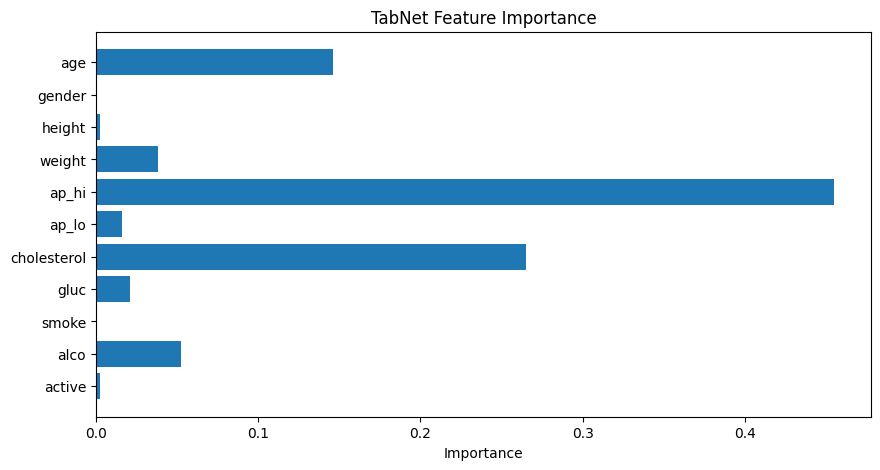

In [ ]:
## Finding features which are importance from TabNet

import matplotlib.pyplot as plt

feature_importances = clf.feature_importances_
feature_names = X.columns

# Plotting the results
plt.figure(figsize=(10, 5))
plt.barh(feature_names, feature_importances)
plt.xlabel("Importance")
plt.title("TabNet Feature Importance")
plt.gca().invert_yaxis()
plt.show()


## Part 2 - Generalization from UCI to Kaggle Dataset

In [1]:
# Importing the required libraries
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Loading and preprocessing the UCI dataset
uci_df = pd.read_csv("/content/heart_disease_uci.csv")
uci_df["cardio"] = uci_df["num"].apply(lambda x: 1 if x > 0 else 0)
uci_df = uci_df[["age", "sex", "trestbps", "chol", "fbs", "exang", "oldpeak", "cardio"]].dropna()
uci_df["gender"] = uci_df["sex"].map({"Male": 1, "Female": 0})
uci_df["gluc"] = uci_df["fbs"].map({True: 1, False: 0})
uci_df["alco"] = 0
uci_df["smoke"] = 0
uci_df["active"] = 1
uci_df["exang"] = uci_df["exang"].astype(int)
uci_df.rename(columns={"trestbps": "ap_hi", "chol": "cholesterol"}, inplace=True)

final_cols = ["age", "gender", "ap_hi", "cholesterol", "gluc", "smoke", "alco", "active", "exang", "cardio"]
uci_final = uci_df[final_cols].astype(float)

#Splitting the UCI dataset into train test sets
X_uci = uci_final.drop("cardio", axis=1)
y_uci = uci_final["cardio"].astype(int)
X_train_uci, X_val_uci, y_train_uci, y_val_uci = train_test_split(
    X_uci, y_uci, test_size=0.2, stratify=y_uci, random_state=42
)

possible_categorical_columns = ["gender", "gluc", "smoke", "alco", "active", "exang"] #preparing categorical columns

categorical_columns = []
cat_idxs = []
cat_dims = []

for col in possible_categorical_columns:
    X_uci[col] = X_uci[col].astype(int)
    min_val = X_uci[col].min()
    if min_val > 0:
        X_uci[col] -= min_val

    n_unique = X_uci[col].nunique()
    if n_unique > 1:
        categorical_columns.append(col)
        cat_idxs.append(X_uci.columns.get_loc(col))
        cat_dims.append(n_unique)
    else:
        print(f"Dropping {col} from embeddings — only 1 unique value: {X_uci[col].unique()}")

print(" Final cat_idxs:", cat_idxs) #Debugging steps
print(" Final cat_dims:", cat_dims)


# Converting to NumPy arrays
X_train_np = X_train_uci.values
X_val_np = X_val_uci.values
y_train_np = y_train_uci.values
y_val_np = y_val_uci.values


clf_uci = TabNetClassifier( #Intializing and training the model
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2,
    optimizer_params=dict(lr=2e-2),
    verbose=1
)

clf_uci.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

#Now let's test it on the other dataset
# Loading and preprocessing the Kaggle dataset
kaggle_df = pd.read_csv("/content/cardio_train.csv", sep=";")
kaggle_df.drop(columns=["id"], inplace=True)

# Converting age from days to years
kaggle_df["age"] = (kaggle_df["age"] / 365).astype(int)

# Applying same transformations as UCI for categorical columns
kaggle_df["gender"] = kaggle_df["gender"].astype(int)
kaggle_df["gluc"] = kaggle_df["gluc"].astype(int)
kaggle_df["smoke"] = kaggle_df["smoke"].astype(int)
kaggle_df["alco"] = kaggle_df["alco"].astype(int)
kaggle_df["active"] = kaggle_df["active"].astype(int)
kaggle_df["exang"] = kaggle_df["exercise_induced_angina"] if "exercise_induced_angina" in kaggle_df.columns else kaggle_df["active"]  # fallback

# Align categorical values
for col, dim in zip(categorical_columns, cat_dims):
    if col in kaggle_df.columns:
        kaggle_df[col] -= kaggle_df[col].min()
        kaggle_df[col] = kaggle_df[col].clip(0, dim - 1)

# Selecting aligned features
X_kaggle = kaggle_df[X_uci.columns]  # this ensures same order and cols
y_kaggle = kaggle_df["cardio"].astype(int)
X_kaggle_np = X_kaggle.values.astype(float)
y_kaggle_np = y_kaggle.values


#Evaluating the UCI-trained model on Kaggle dataset
y_pred_kaggle = clf_uci.predict(X_kaggle_np)
y_proba_kaggle = clf_uci.predict_proba(X_kaggle_np)[:, 1]

acc = accuracy_score(y_kaggle_np, y_pred_kaggle)
prec = precision_score(y_kaggle_np, y_pred_kaggle)
rec = recall_score(y_kaggle_np, y_pred_kaggle)
f1 = f1_score(y_kaggle_np, y_pred_kaggle)
auc = roc_auc_score(y_kaggle_np, y_proba_kaggle)
report = classification_report(y_kaggle_np, y_pred_kaggle)
conf_matrix = confusion_matrix(y_kaggle_np, y_pred_kaggle)

# Last step for generalization results
print(" Generalization Evaluation (Train on UCI -> Test on Kaggle)")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC      : {auc:.4f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Dropping smoke from embeddings — only 1 unique value: [0]
Dropping alco from embeddings — only 1 unique value: [0]
Dropping active from embeddings — only 1 unique value: [0]
Final cat_idxs: [1, 4, 8]
Final cat_dims: [2, 2, 2]
epoch 0 | loss: 0.84145 | val_accuracy: 0.36913 | 0:00:00s
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch  1 | loss: 0.68763 | val_accuracy: 0.57047 | 0:00:00s
epoch  2 | loss: 0.62571 | val_accuracy: 0.50336 | 0:00:00s
epoch  3 | loss: 0.60314 | val_accuracy: 0.52349 | 0:00:00s
epoch  4 | loss: 0.55447 | val_accuracy: 0.45638 | 0:00:00s
epoch  5 | loss: 0.56019 | val_accuracy: 0.38926 | 0:00:00s
epoch  6 | loss: 0.56681 | val_accuracy: 0.44966 | 0:00:01s
epoch  7 | loss: 0.56031 | val_accuracy: 0.50336 | 0:00:01s
epoch  8 | loss: 0.53705 | val_accuracy: 0.48322 | 0:00:01s
epoch  9 | loss: 0.51109 | val_accuracy: 0.48993 | 0:00:01s
epoch 10 | loss: 0.

## Next Attempt to improve generalization

In [2]:
# Importing requeried libraries
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Loading and preprocess UCI dataset again
uci_df = pd.read_csv("/content/heart_disease_uci.csv")
uci_df["cardio"] = uci_df["num"].apply(lambda x: 1 if x > 0 else 0)
uci_df = uci_df[["age", "sex", "trestbps", "chol", "fbs", "exang", "oldpeak", "cardio"]].dropna()
uci_df["gender"] = uci_df["sex"].map({"Male": 1, "Female": 0})
uci_df["gluc"] = uci_df["fbs"].map({True: 1, False: 0})
uci_df["alco"] = 0
uci_df["smoke"] = 0
uci_df["active"] = 1
uci_df["exang"] = uci_df["exang"].astype(int)
uci_df.rename(columns={"trestbps": "ap_hi", "chol": "cholesterol"}, inplace=True)

final_cols = ["age", "gender", "ap_hi", "cholesterol", "gluc", "smoke", "alco", "active", "exang", "cardio"]
uci_df = uci_df[final_cols].astype(float)

# Splitting into Train test sets
X_uci = uci_df.drop("cardio", axis=1)
y_uci = uci_df["cardio"].astype(int)
X_train_uci, X_val_uci, y_train_uci, y_val_uci = train_test_split(
    X_uci, y_uci, test_size=0.2, stratify=y_uci, random_state=42
)

cat_cols = ["gender", "gluc", "smoke", "alco", "active", "exang"]
cat_idxs, cat_dims = [], []

for col in cat_cols: # Loop handles categorical encoding
    unique_vals = X_uci[col].nunique()
    if unique_vals > 1:
        idx = X_uci.columns.get_loc(col)
        cat_idxs.append(idx)
        cat_dims.append(unique_vals)
    else:
        print(f" Skipping {col}, only one unique value: {X_uci[col].unique()}")

print(" cat_idxs:", cat_idxs) #Debugging check
print(" cat_dims:", cat_dims)

# Applying shift & clip to train categorical columns
for col, dim in zip(cat_cols, cat_dims):
    if col in X_uci.columns:
        X_uci[col] = X_uci[col].astype(int)
        X_uci[col] = X_uci[col] - X_uci[col].min()
        X_uci[col] = X_uci[col].clip(0, dim - 1)

X_train_np = X_uci.loc[X_train_uci.index].values # Re-splitting after transformations
X_val_np = X_uci.loc[X_val_uci.index].values
y_train_np = y_train_uci.values
y_val_np = y_val_uci.values

# Now training TabNet
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2,
    optimizer_params=dict(lr=2e-2),
    verbose=1
)

clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# Now moving onto the next part. Loading and preprocessing the Kaggle dataset
kaggle_df = pd.read_csv("/content/cardio_train.csv", sep=";")
kaggle_df.drop(columns=["id"], inplace=True)
kaggle_df["age"] = (kaggle_df["age"] / 365).astype(int)

# Adding missing columns from UCI
kaggle_df["oldpeak"] = 0
if "exang" not in kaggle_df.columns:
    kaggle_df["exang"] = 0

for col, dim in zip(cat_cols, cat_dims):
    if col in kaggle_df.columns:
        kaggle_df[col] = kaggle_df[col].astype(int)
        kaggle_df[col] = kaggle_df[col] - kaggle_df[col].min()
        kaggle_df[col] = kaggle_df[col].clip(0, dim - 1)

# Aligning the features with UCI model
X_kaggle = kaggle_df[X_uci.columns]
y_kaggle = kaggle_df["cardio"].astype(int)

X_kaggle_np = X_kaggle.values.astype(float)
y_kaggle_np = y_kaggle.values

# Evualting the model on the dataset
y_pred_kaggle = clf.predict(X_kaggle_np)
y_proba_kaggle = clf.predict_proba(X_kaggle_np)[:, 1]

acc = accuracy_score(y_kaggle_np, y_pred_kaggle)
prec = precision_score(y_kaggle_np, y_pred_kaggle)
rec = recall_score(y_kaggle_np, y_pred_kaggle)
f1 = f1_score(y_kaggle_np, y_pred_kaggle)
auc = roc_auc_score(y_kaggle_np, y_proba_kaggle)
report = classification_report(y_kaggle_np, y_pred_kaggle)
conf_matrix = confusion_matrix(y_kaggle_np, y_pred_kaggle)

print("\n Generalization Results (Train on UCI → Test on Kaggle)")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC      : {auc:.4f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Skipping smoke, only one unique value: [0.]
Skipping alco, only one unique value: [0.]
Skipping active, only one unique value: [1.]
cat_idxs: [1, 4, 8]
cat_dims: [2, 2, 2]
epoch  0 | loss: 0.84145 | val_accuracy: 0.36913 | 0:00:00s
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch  1 | loss: 0.68763 | val_accuracy: 0.57047 | 0:00:00s
epoch  2 | loss: 0.62571 | val_accuracy: 0.50336 | 0:00:00s
epoch  3 | loss: 0.58762 | val_accuracy: 0.52349 | 0:00:00s
epoch  4 | loss: 0.55447 | val_accuracy: 0.45638 | 0:00:00s
epoch  5 | loss: 0.56019 | val_accuracy: 0.38926 | 0:00:00s
epoch  6 | loss: 0.56681 | val_accuracy: 0.44966 | 0:00:00s
epoch  7 | loss: 0.56031 | val_accuracy: 0.50336 | 0:00:00s
epoch  8 | loss: 0.53705 | val_accuracy: 0.48322 | 0:00:00s
epoch  9 | loss: 0.51109 | val_accuracy: 0.48993 | 0:00:00s
epoch 10 | loss: 0.51265 | val_accuracy: 0.48322 | 0:00:00s
epoch 11 | l

## Plotting the AUROC and AUPRC Plots

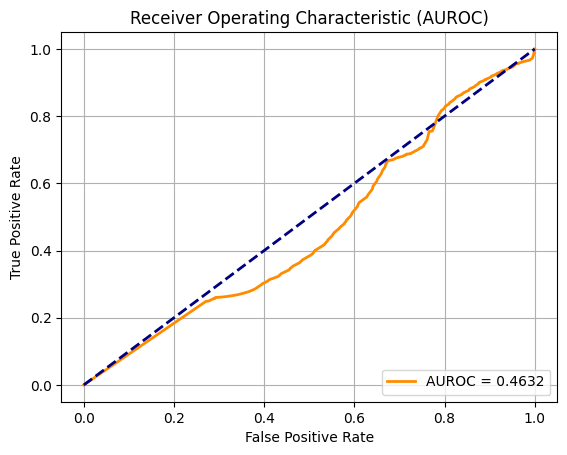

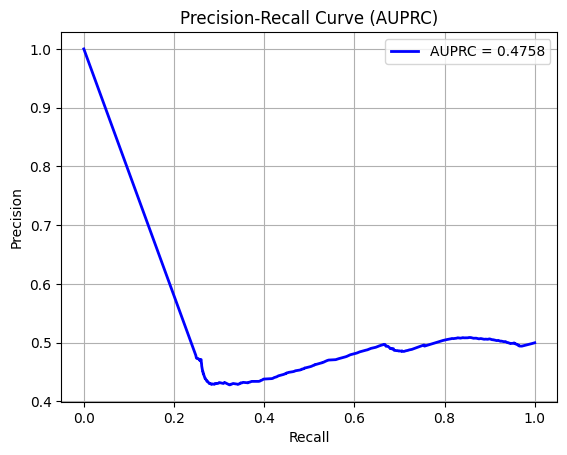

In [ ]:
# Importing the requried libraries
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Predicting the probabilities from TabNet model
y_scores = clf.predict_proba(X_kaggle_np)[:, 1]  # probability of class 1
y_true = y_kaggle_np

# AUROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# AUPRC curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
auprc = average_precision_score(y_true, y_scores)

# Plotting the AUROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plotting the AUPRC
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Attempt 3 - Hyperparameter tuning on UCI Dataset and then testing it on Kaggle Dataset

In [8]:
# Importing required libraries
import pandas as pd
import numpy as np
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import torch

np.random.seed(42)

# Loading and preprocessing the UCI dataset
uci_df = pd.read_csv("/content/heart_disease_uci.csv")
uci_df["cardio"] = uci_df["num"].apply(lambda x: 1 if x > 0 else 0)
uci_df = uci_df[["age", "sex", "trestbps", "chol", "fbs", "exang", "oldpeak", "cardio"]].dropna()
uci_df["gender"] = uci_df["sex"].map({"Male": 1, "Female": 0})
uci_df["gluc"] = uci_df["fbs"].map({True: 1, False: 0})
uci_df["alco"] = 0
uci_df["smoke"] = 0
uci_df["active"] = 1
uci_df["exang"] = uci_df["exang"].astype(int)
uci_df.rename(columns={"trestbps": "ap_hi", "chol": "cholesterol"}, inplace=True)

final_cols = ["age", "gender", "ap_hi", "cholesterol", "gluc", "smoke", "alco", "active", "exang", "cardio"]
uci_df = uci_df[final_cols].astype(float)

# Splitting into train test set
X = uci_df.drop("cardio", axis=1)
y = uci_df["cardio"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_cols = ["gender", "gluc", "smoke", "alco", "active", "exang"]
cat_idxs, cat_dims = [], []
for col in cat_cols: # Handling categorical columns
    n_unique = X[col].nunique()
    if n_unique > 1:
        idx = X.columns.get_loc(col)
        cat_idxs.append(idx)
        cat_dims.append(n_unique)
    else:
        print(f" Skipping {col}, only 1 unique value: {X[col].unique()}")

for col, dim in zip(cat_cols, cat_dims): # Shifting and clipping
    X_train[col] = (X_train[col] - X_train[col].min()).clip(0, dim - 1).astype(int)
    X_val[col] = (X_val[col] - X_val[col].min()).clip(0, dim - 1).astype(int)

# Converting to NumPy
X_train_np = X_train.values.astype(float)
X_val_np = X_val.values.astype(float)
y_train_np = y_train.values
y_val_np = y_val.values

# Trying optuna objective
def objective(trial):
    clf = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=trial.suggest_int("cat_emb_dim", 1, 10),
        n_d=trial.suggest_int("n_d", 8, 64),
        n_a=trial.suggest_int("n_a", 8, 64),
        n_steps=trial.suggest_int("n_steps", 3, 10),
        gamma=trial.suggest_float("gamma", 1.0, 2.0),
        optimizer_params=dict(lr=trial.suggest_float("lr", 1e-3, 2e-2)),
        verbose=0,
        seed=42
    )

    clf.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_val_np, y_val_np)],
        eval_name=["val"],
        eval_metric=["accuracy"],
        max_epochs=50,
        patience=10,
        batch_size=128,
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False,
    )

    preds = clf.predict(X_val_np)
    return accuracy_score(y_val_np, preds)

# Running optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


[I 2025-06-02 23:53:12,983] A new study created in memory with name: no-name-7ec80e52-d84f-4368-b32b-8f1dca96ac62
Skipping smoke, only 1 unique value: [0.]
Skipping alco, only 1 unique value: [0.]
Skipping active, only 1 unique value: [1.]
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-02 23:53:28,139] Trial 0 finished with value: 0.6375838926174496 and parameters: {'cat_emb_dim': 5, 'n_d': 28, 'n_a': 33, 'n_steps': 10, 'gamma': 1.415940968359433, 'lr': 0.012730973629185318}. Best is trial 0 with value: 0.6375838926174496.
Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_accuracy = 0.63758
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-02 23:53:30,024] Trial 1 finished with value: 0.5302013422818792 and parameters

In [4]:
print("\n Best Hyperparameters Found:")
best_params = study.best_params
for k, v in best_params.items():
    print(f"{k}: {v}")

# Trainning with the best hyperparameters
clf_final = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=best_params["cat_emb_dim"],
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    optimizer_params=dict(lr=best_params["lr"]),
    verbose=1,
    seed=42
)

clf_final.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=128,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
)

loss_history = clf_final.history["loss"]
acc_history = clf_final.history["val_accuracy"]



Best Hyperparameters Found:
cat_emb_dim: 10
n_d: 60
n_a: 32
n_steps: 3
gamma: 1.8619312083550193
lr: 0.014319122261569815
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch  0 | loss: 0.80303 | val_accuracy: 0.50336 | 0:00:00s
epoch  1 | loss: 0.64116 | val_accuracy: 0.64430 | 0:00:01s
epoch  2 | loss: 0.66664 | val_accuracy: 0.46309 | 0:00:02s
epoch  3 | loss: 0.57421 | val_accuracy: 0.41611 | 0:00:03s
epoch  4 | loss: 0.54388 | val_accuracy: 0.41611 | 0:00:04s
epoch  5 | loss: 0.52572 | val_accuracy: 0.42953 | 0:00:01s
epoch  6 | loss: 0.53573 | val_accuracy: 0.53691 | 0:00:02s
epoch  7 | loss: 0.54119 | val_accuracy: 0.52349 | 0:00:03s
epoch  8 | loss: 0.49363 | val_accuracy: 0.63758 | 0:00:04s
epoch  9 | loss: 0.50791 | val_accuracy: 0.61074 | 0:00:05s
epoch 10 | loss: 0.48119 | val_accuracy: 0.48322 | 0:00:02s
epoch 11 | loss: 0.49409 | val_accuracy: 0.72483 | 0:00:03s
ep


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_accuracy = 0.7651
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


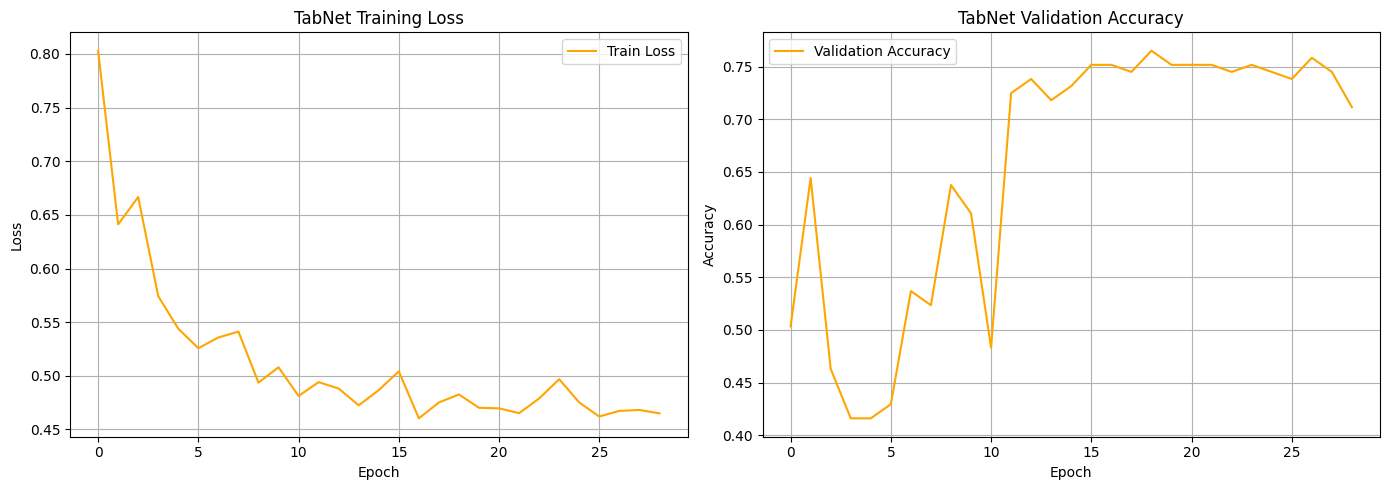

In [5]:
# Plotting the loss and accuracy plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Train Loss")
plt.title("TabNet Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label="Validation Accuracy")
plt.title("TabNet Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
# Now Evaluating the tuned model on full Kaggle dataset
y_pred_kaggle = clf_final.predict(X_kaggle_np)
y_proba_kaggle = clf_final.predict_proba(X_kaggle_np)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

print(" Test ROC AUC:", roc_auc_score(y_kaggle_np, y_proba_kaggle))
print(" Test F1 Score:", f1_score(y_kaggle_np, y_pred_kaggle))
print("\nClassification Report:\n", classification_report(y_kaggle_np, y_pred_kaggle))
print("Confusion Matrix:\n", confusion_matrix(y_kaggle_np, y_pred_kaggle))


Test ROC AUC: 0.4710881189794779
Test F1 Score: 0.6373310609963934

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.04      0.06     35021
           1       0.49      0.92      0.64     34979

    accuracy                           0.48     70000
   macro avg       0.40      0.48      0.35     70000
weighted avg       0.40      0.48      0.35     70000

Confusion Matrix:
[[ 1237 33784]
 [ 2818 32161]]


## Attempt 4 - Re try with Hyperparameter tuning on UCI Dataset and then testing it on Kaggle Dataset

In [11]:
# Importing the required libraries
import pandas as pd
import numpy as np
import torch
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(42)

# Loading and preprocessing the UCI dataset
uci_df = pd.read_csv("/content/heart_disease_uci.csv")
uci_df["cardio"] = uci_df["num"].apply(lambda x: 1 if x > 0 else 0)
uci_df = uci_df[["age", "sex", "trestbps", "chol", "fbs", "exang", "oldpeak", "cardio"]].dropna()
uci_df["gender"] = uci_df["sex"].map({"Male": 1, "Female": 0})
uci_df["gluc"] = uci_df["fbs"].map({True: 1, False: 0})
uci_df["alco"] = 0
uci_df["smoke"] = 0
uci_df["active"] = 1
uci_df["exang"] = uci_df["exang"].astype(int)
uci_df.rename(columns={"trestbps": "ap_hi", "chol": "cholesterol"}, inplace=True)

final_cols = ["age", "gender", "ap_hi", "cholesterol", "gluc", "smoke", "alco", "active", "exang", "cardio"]
uci_df = uci_df[final_cols].astype(float)

#Splitting teh dataset into tarining and validation sets
X = uci_df.drop("cardio", axis=1)
y = uci_df["cardio"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_cols = ["gender", "gluc", "smoke", "alco", "active", "exang"]
cat_idxs, cat_dims = [], []
for col in cat_cols:   # Categorical column processing
    n_unique = X[col].nunique()
    if n_unique > 1:
        cat_idxs.append(X.columns.get_loc(col))
        cat_dims.append(n_unique)
    else:
        print(f" Skipping {col}, only one unique value: {X[col].unique()}")

for col, dim in zip(cat_cols, cat_dims):
    X_train[col] = (X_train[col] - X_train[col].min()).clip(0, dim - 1).astype(int)
    X_val[col] = (X_val[col] - X_val[col].min()).clip(0, dim - 1).astype(int)

X_train_np = X_train.values.astype(float)
X_val_np = X_val.values.astype(float)
y_train_np = y_train.values
y_val_np = y_val.values

# Optuna objective intialising
def objective(trial):
    clf = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=trial.suggest_int("cat_emb_dim", 2, 16),
        n_d=trial.suggest_int("n_d", 8, 64),
        n_a=trial.suggest_int("n_a", 8, 64),
        n_steps=trial.suggest_int("n_steps", 3, 10),
        gamma=trial.suggest_float("gamma", 1.0, 2.5),
        lambda_sparse=trial.suggest_float("lambda_sparse", 1e-6, 1e-3),
        momentum=trial.suggest_float("momentum", 0.01, 0.4),
        optimizer_params=dict(lr=trial.suggest_float("lr", 1e-4, 2e-2)),
        scheduler_params={"step_size": 10, "gamma": 0.95},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        seed=42,
        verbose=0
    )
    clf.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_val_np, y_val_np)],
        eval_name=["val"],
        eval_metric=["accuracy"],
        max_epochs=50,
        patience=10,
        batch_size=128,
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False,
    )
    preds = clf.predict(X_val_np)
    return accuracy_score(y_val_np, preds)

# Running the Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Showing best hyperparameters
print("\n Best Hyperparameters Found:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2025-06-03 00:20:26,410] A new study created in memory with name: no-name-79d7e744-56c4-4988-90e8-6f7bad0df9ed
Skipping smoke, only one unique value: [0.]
Skipping alco, only one unique value: [0.]
Skipping active, only one unique value: [1.]
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-03 00:20:33,416] Trial 0 finished with value: 0.6577181208053692 and parameters: {'cat_emb_dim': 6, 'n_d': 47, 'n_a': 49, 'n_steps': 5, 'gamma': 2.243989449733245, 'lambda_sparse': 0.00018435240049082308, 'momentum': 0.3685811581406014, 'lr': 0.014858660393078794}. Best is trial 0 with value: 0.6577181208053692.

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_accuracy = 0.65772
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-0

In [13]:
#importing the requried libraries
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import torch

np.random.seed(42)

# Loading and preprocessing the UCI dataset

uci_df = pd.read_csv("/content/heart_disease_uci.csv")
uci_df["cardio"] = uci_df["num"].apply(lambda x: 1 if x > 0 else 0)
uci_df = uci_df[["age", "sex", "trestbps", "chol", "fbs", "exang", "oldpeak", "cardio"]].dropna()

# Feature engineering step
uci_df["gender"] = uci_df["sex"].map({"Male": 1, "Female": 0})
uci_df["gluc"] = uci_df["fbs"].map({True: 1, False: 0})
uci_df["alco"] = 0
uci_df["smoke"] = 0
uci_df["active"] = 1
uci_df["exang"] = uci_df["exang"].astype(int)
uci_df.rename(columns={"trestbps": "ap_hi", "chol": "cholesterol"}, inplace=True)

final_cols = ["age", "gender", "ap_hi", "cholesterol", "gluc", "smoke", "alco", "active", "exang", "cardio"]
uci_df = uci_df[final_cols].astype(float)

# Splitting the feature
X_uci = uci_df.drop("cardio", axis=1)
y_uci = uci_df["cardio"]

cat_cols = ["gender", "gluc", "smoke", "alco", "active", "exang"]
cat_idxs, cat_dims = [], []

for col in cat_cols: #Handling the Categorical Columns
    if X_uci[col].nunique() > 1:
        idx = X_uci.columns.get_loc(col)
        cat_idxs.append(idx)
        cat_dims.append(X_uci[col].nunique())

for col, dim in zip(cat_cols, cat_dims):
    X_uci[col] = (X_uci[col] - X_uci[col].min()).clip(0, dim - 1).astype(int)

X_uci_np = X_uci.values.astype(float)
y_uci_np = y_uci.values

# Training the final TabNet model
clf_final = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=8,
    n_d=29,
    n_a=53,
    n_steps=6,
    gamma=1.8529646367354422,
    lambda_sparse=0.0006493531540795046,
    momentum=0.16355147675860365,
    optimizer_params=dict(lr=0.01934354385120534),
    verbose=1,
    seed=42
)

clf_final.fit(
    X_train=X_uci_np, y_train=y_uci_np,
    eval_set=[(X_uci_np, y_uci_np)],
    eval_name=["train"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=128,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False,
)

# Loading and preprocess Kaggle dataset
kaggle_df = pd.read_csv("/content/cardio_train.csv", sep=";")
kaggle_df.drop(columns=["id"], inplace=True)
kaggle_df["age"] = (kaggle_df["age"] / 365).astype(int)

# Adding the missing features from UCI
if "exang" not in kaggle_df.columns:
    kaggle_df["exang"] = 0
if "oldpeak" not in kaggle_df.columns:
    kaggle_df["oldpeak"] = 0

for col, dim in zip(cat_cols, cat_dims):
    if col in kaggle_df.columns:
        kaggle_df[col] = (kaggle_df[col] - kaggle_df[col].min()).clip(0, dim - 1).astype(int)

X_kaggle = kaggle_df[X_uci.columns]
y_kaggle = kaggle_df["cardio"].astype(int)

X_kaggle_np = X_kaggle.values.astype(float)
y_kaggle_np = y_kaggle.values

# Evaluating on the Kaggle
y_pred_kaggle = clf_final.predict(X_kaggle_np)
y_proba_kaggle = clf_final.predict_proba(X_kaggle_np)[:, 1]

print("\n Evaluation on Kaggle Dataset:")
print("Accuracy     :", accuracy_score(y_kaggle_np, y_pred_kaggle))
print("Precision    :", precision_score(y_kaggle_np, y_pred_kaggle))
print("Recall       :", recall_score(y_kaggle_np, y_pred_kaggle))
print("F1 Score     :", f1_score(y_kaggle_np, y_pred_kaggle))
print("ROC AUC      :", roc_auc_score(y_kaggle_np, y_proba_kaggle))

print("\nClassification Report:\n", classification_report(y_kaggle_np, y_pred_kaggle))
print("Confusion Matrix:\n", confusion_matrix(y_kaggle_np, y_pred_kaggle))



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 1.47888 | train_accuracy: 0.51012 | 0:00:00s
epoch 1  | loss: 0.74355 | train_accuracy: 0.44534 | 0:00:02s
epoch 2  | loss: 0.73343 | train_accuracy: 0.60459 | 0:00:03s
epoch 3  | loss: 0.81062 | train_accuracy: 0.55601 | 0:00:05s
epoch 4  | loss: 0.68462 | train_accuracy: 0.45344 | 0:00:06s
epoch 5  | loss: 0.55614 | train_accuracy: 0.61943 | 0:00:07s
epoch 6  | loss: 0.52458 | train_accuracy: 0.4413 | 0:00:08s
epoch 7  | loss: 0.55246 | train_accuracy: 0.61269 | 0:00:09s
epoch 8  | loss: 0.53691 | train_accuracy: 0.57625 | 0:00:08s
epoch 9  | loss: 0.53873 | train_accuracy: 0.65722 | 0:00:09s
epoch 10 | loss: 0.52973 | train_accuracy: 0.70445 | 0:00:09s
epoch 11 | loss: 0.52067 | train_accuracy: 0.66397 | 0:00:10s
epoch 12 | loss: 0.5232  | train_accuracy: 0.66522 | 0:00:10s
epoch 13 | loss: 0.51098 | train_accur

## Attempt 5 - Different Hyperparamters

In [14]:
#Importing required libraries
import pandas as pd
import numpy as np
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Loading the Kaggle dataset again
df = pd.read_csv("/content/cardio_train.csv", sep=";")
df = df.drop("id", axis=1)

# Cleaning the data
df = df[(df["ap_hi"] > 0) & (df["ap_lo"] > 0) & (df["ap_hi"] < 300) & (df["ap_lo"] < 200)]
df = df[df["height"] > 100]
df = df[df["weight"] > 30]

# Feature engineering
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

# Shift categorical features to start from 0
cat_features = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
for col in cat_features:
    df[col] = df[col].astype(int) - df[col].min()

# Selecting the features and target
features = ["age", "gender", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "bmi"]
target = "cardio"

X = df[features].astype(np.float32)
y = df[target].astype(int)

# Spliting the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_idxs = [X.columns.get_loc(col) for col in cat_features]
cat_dims = [int(X[col].nunique()) for col in cat_features]

X_train_np = X_train.values
X_val_np = X_val.values
y_train_np = y_train.values
y_val_np = y_val.values

# Optuna intialisation
def objective(trial):
    clf = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=trial.suggest_int("cat_emb_dim", 1, 10),
        n_d=trial.suggest_int("n_d", 16, 64),
        n_a=trial.suggest_int("n_a", 16, 64),
        n_steps=trial.suggest_int("n_steps", 3, 10),
        gamma=trial.suggest_float("gamma", 1.0, 2.5),
        lambda_sparse=trial.suggest_float("lambda_sparse", 1e-5, 1e-3),
        momentum=trial.suggest_float("momentum", 0.01, 0.4),
        optimizer_params=dict(lr=trial.suggest_float("lr", 1e-3, 2e-2)),
        seed=42,
        verbose=0
    )

    clf.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_val_np, y_val_np)],
        eval_metric=["accuracy"],
        max_epochs=50,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    preds = clf.predict(X_val_np)
    return accuracy_score(y_val_np, preds)

# Running the optuna tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Getting the best hyperparameters
print("Best Hyperparameters Found:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")



[I 2025-06-03 05:10:48,262] A new study created in memory with name: no-name-b8a3f177-5c09-4c92-ba64-6f2e1148eabb

Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_accuracy = 0.72993
[I 2025-06-03 05:15:48,590] Trial 0 finished with value: 0.7299296540720864 and parameters: {'cat_emb_dim': 2, 'n_d': 62, 'n_a': 19, 'n_steps': 7, 'gamma': 1.2937083254716852, 'lambda_sparse': 0.0003078770339744412, 'momentum': 0.05219689651795022, 'lr': 0.007322715241857678}. Best is trial 0 with value: 0.7299296540720864.

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_accuracy = 0.72746
[I 2025-06-03 05:19:49,970] Trial 1 finished with value: 0.7274639205163537 and parameters: {'cat_emb_dim': 3, 'n_d': 39, 'n_a': 39, 'n_steps': 4, 'gamma': 2.3164634007184315, 'lambda_sparse': 0.000673933011350401, 'momentum': 0.042588522498851526, 'lr': 0.011904599382383012}. Best is trial 0 with value: 0.7299296540720864.

Early stopping occurred at epoch 21 with best_ep

In [16]:
# Importing requried libraries
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import torch

np.random.seed(42)

#Loading the kaggle dataset
df = pd.read_csv("/content/cardio_train.csv", sep=";")

# Drop ID column
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

df = df[(df["ap_hi"] > 50) & (df["ap_hi"] < 250)]
df = df[(df["ap_lo"] > 30) & (df["ap_lo"] < 200)]

# Defining categorical columns and target
target_col = "cardio"
cat_cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

# Separating the features and target
X = df.drop(columns=[target_col])
y = df[target_col]

for col in cat_cols:
    X[col] = X[col].astype(int)
    X[col] = X[col] - X[col].min()

cat_idxs = [X.columns.get_loc(col) for col in cat_cols]
cat_dims = [X[col].nunique() for col in cat_cols]

# Converting to NumPy arrays
X_np = X.values.astype(np.float32)
y_np = y.values

# Splitting into train test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# TabNet best hyperparameters from Optuna
clf_final = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=6,
    n_d=16,
    n_a=64,
    n_steps=3,
    gamma=1.0222344458473958,
    lambda_sparse=0.000704129400220928,
    momentum=0.25351406195045556,
    optimizer_params=dict(lr=0.018955517605722304),
    verbose=1,
    seed=42
)

# Training the model
clf_final.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# Evaluating the model
preds = clf_final.predict(X_test_np)
probs = clf_final.predict_proba(X_test_np)[:, 1]

acc = accuracy_score(y_test_np, preds)
prec = precision_score(y_test_np, preds)
rec = recall_score(y_test_np, preds)
f1 = f1_score(y_test_np, preds)
roc = roc_auc_score(y_test_np, probs)

print("\n Evaluation on Kaggle Dataset:")
print(f"Accuracy     : {acc}")
print(f"Precision    : {prec}")
print(f"Recall       : {rec}")
print(f"F1 Score     : {f1}")
print(f"ROC AUC      : {roc}\n")

print("Classification Report:")
print(classification_report(y_test_np, preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test_np, preds))



epoch 0  | loss: 0.51907 | test_accuracy: 0.39193 | 0:00:09s
epoch 1  | loss: 0.55801 | test_accuracy: 0.49604 | 0:00:15s
epoch 2  | loss: 0.54927 | test_accuracy: 0.51756 | 0:00:22s
epoch 3  | loss: 0.5487  | test_accuracy: 0.56881 | 0:00:28s
epoch 4  | loss: 0.54844 | test_accuracy: 0.68862 | 0:00:34s
epoch 5  | loss: 0.54675 | test_accuracy: 0.71443 | 0:00:40s
epoch 6  | loss: 0.54735 | test_accuracy: 0.71429 | 0:00:47s
epoch 7  | loss: 0.5483  | test_accuracy: 0.72228 | 0:00:53s
epoch 8  | loss: 0.54557 | test_accuracy: 0.72592 | 0:00:59s
epoch 9  | loss: 0.54557 | test_accuracy: 0.72512 | 0:01:06s
epoch 10 | loss: 0.54441 | test_accuracy: 0.72904 | 0:01:12s
epoch 11 | loss: 0.54432 | test_accuracy: 0.72694 | 0:01:19s
epoch 12 | loss: 0.54467 | test_accuracy: 0.72664 | 0:01:25s
epoch 13 | loss: 0.54521 | test_accuracy: 0.73006 | 0:01:32s
epoch 14 | loss: 0.54466 | test_accuracy: 0.72672 | 0:01:37s
epoch 15 | loss: 0.54402 | test_accuracy: 0.72795 | 0:01:44s
epoch 16 | loss: 0.5439

## Part 3 - Trying the Generlization in teh other direction. Training on Kaggle dataset and then  testing on UCI

In [ ]:
#Installing reqruied libraies
!pip install pytorch-tabnet
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
#Installing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder

# Loading and preprocessing the kaggle dataset
kaggle_df = pd.read_csv("cardio_train.csv", sep=';')

def preprocess_kaggle(df):
    df = df.copy()
    df.drop(columns=["id", "height", "weight"], inplace=True, errors="ignore")
    df["age"] = (df["age"] / 365).astype(int)
    y = df["cardio"].values
    X = df.drop(columns=["cardio"])
    categorical_columns = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
    for col in categorical_columns:
        X[col] = X[col].astype("category")
    return X, y, categorical_columns


def impute_missing_values(X_df):
    X_df = X_df.copy()
    cat_cols = X_df.select_dtypes("category").columns
    num_cols = X_df.select_dtypes(include=["int", "float"]).columns

    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy="median")
        X_df[num_cols] = num_imputer.fit_transform(X_df[num_cols])

    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        X_df[cat_cols] = cat_imputer.fit_transform(X_df[cat_cols])
        for col in cat_cols:
            X_df[col] = X_df[col].astype("category")

    return X_df

# Preprocessing the Kaggle
kaggle_X, kaggle_y, cat_cols = preprocess_kaggle(kaggle_df)
kaggle_X = impute_missing_values(kaggle_X)

In [18]:
# Label encoding the categorical features numerically before SMOTE
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    kaggle_X[col] = le.fit_transform(kaggle_X[col])
    label_encoders[col] = le

#Splitting into the training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(kaggle_X, kaggle_y, test_size=0.2, stratify=kaggle_y, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Recasting the categorical columns + clip to avoid index error
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

for col in cat_cols:
    max_class = kaggle_X[col].max()
    X_train_resampled[col] = np.clip(X_train_resampled[col].round().astype(int), 0, max_class)
    X_train_resampled[col] = X_train_resampled[col].astype("category")

for col in cat_cols: # Restoring the validation set categorical columns
    X_valid[col] = kaggle_X[col].loc[X_valid.index]
    X_valid[col] = X_valid[col].astype("category")
X_train_resampled = impute_missing_values(X_train_resampled)
X_valid = impute_missing_values(X_valid)


#Training Tabnet
clf = TabNetClassifier(
    cat_idxs=[X_train.columns.get_loc(col) for col in X_train.select_dtypes("category").columns],
    cat_dims=[X_train[col].nunique() for col in X_train.select_dtypes("category").columns],
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":10, "gamma":0.9},
    verbose=10,
    seed=42
)

clf.fit(
    X_train=X_train_resampled.values,
    y_train=y_train_resampled,
    eval_set=[(X_valid.values, y_valid)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Loading and preprocessing the dataset
uci_df = pd.read_csv("heart_disease_uci.csv")

from sklearn.preprocessing import LabelEncoder

def preprocess_uci(df, cat_cols):
    df = df.copy()
    df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]
    y = df["num"].apply(lambda x: 1 if x > 0 else 0).values

    df = df.drop(columns=["id", "num", "dataset"], errors="ignore") # Dropping and renaming to match Kaggle features
    rename_map = {
        "sex": "gender",
        "cp": "cholesterol",
        "fbs": "gluc",
        "thalch": "ap_hi",
        "restecg": "ap_lo",
        "exang": "smoke",
        "slope": "alco",
        "thal": "active"
    }
    df = df.rename(columns=rename_map)

    expected_features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
                         'smoke', 'alco', 'active', 'gender']

    # Adding missing features
    for col in expected_features:
        if col not in df.columns:
            df[col] = 0

    df = df[expected_features]

    # Encoding the string categorical columns
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Matching the TabNet expectations
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df, y

uci_X, uci_y = preprocess_uci(uci_df, cat_cols)
uci_X = impute_missing_values(uci_X)

# Ensuring feature count and order match
uci_X = uci_X[X_train_resampled.columns]

# Predicting and evaluating
uci_preds = clf.predict(uci_X.values)

print("GENERALIZATION TEST: TabNet Trained on Kaggle, Tested on UCI")
print("Accuracy :", accuracy_score(uci_y, uci_preds))
print("Precision:", precision_score(uci_y, uci_preds))
print("Recall   :", recall_score(uci_y, uci_preds))
print("F1 Score :", f1_score(uci_y, uci_preds))
print("AUROC    :", roc_auc_score(uci_y, uci_preds))
print("Confusion Matrix:\n", confusion_matrix(uci_y, uci_preds))



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 0.62404 | valid_accuracy: 0.49957 |  0:00:05s
epoch 10 | loss: 0.54821 | valid_accuracy: 0.67043 |  0:00:36s
epoch 20 | loss: 0.54723 | valid_accuracy: 0.69464 |  0:01:04s

Early stopping occurred at epoch 21 with best_epoch = 11 and best_valid_accuracy = 0.69907
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
GENERALIZATION TEST: TabNet Trained on Kaggle, Tested on UCI
Accuracy : 0.4771739130434783
Precision: 0.5251798561151079
Recall   : 0.5736738703339882
F1 Score : 0.5483568075117371
AUROC    : 0.46566905195531527
Confusion Matrix:
 [[147 264]
 [217 292]]



## Part 4 - Experiments where Tabnet is tarined on UCI and Kaggle Dataset and then tested on UCI Dataset. Also the best result after transfer learning

In [ ]:
#Installing requried libraries
!pip install pytorch-tabnet imbalanced-learn


In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import os


In [ ]:
#Writing functions to preprocess kaggle and UCI dataste
def preprocess_kaggle(df):
    df = df.copy()
    df.drop(columns=["id"], inplace=True, errors="ignore")
    df["age"] = (df["age"] / 365).astype(int)
    y = df["cardio"].values
    X = df.drop(columns=["cardio"])
    cat_cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
    for col in cat_cols:
        X[col] = X[col].astype("category")
    return X, y, cat_cols

def preprocess_uci(df, target_col="num"):
    df = df.copy()
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
    df.drop(columns=["id", "dataset"], inplace=True, errors="ignore")
    # y = df[target_col].values
    y = (df[target_col] > 0).astype(int).values
    X = df.drop(columns=[target_col], errors="ignore")

    for col in X.columns:
        if X[col].dtype == object:
            X[col] = X[col].astype("category")
        elif str(X[col].dtype).startswith("int"):
            X[col] = X[col].astype(float)

    return X, y

def impute_and_align(X, reference_cols):
    df = X.copy()
    num_cols = df.select_dtypes(include=["int", "float"]).columns
    cat_cols = df.select_dtypes(include=["category"]).columns

    if len(num_cols) > 0:
        df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
    if len(cat_cols) > 0:
        df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
        for col in cat_cols:
            df[col] = df[col].astype("category")

    for col in reference_cols:
        if col not in df.columns:
            df[col] = 0
    df = df[reference_cols]

    return df


In [ ]:
# Loading the datasets
kaggle_df = pd.read_csv("cardio_train.csv", sep=';')
uci_df = pd.read_csv("heart_disease_uci.csv")

# Processing the Kaggle
kaggle_X, kaggle_y, kaggle_cat_cols = preprocess_kaggle(kaggle_df)

# Processing the UCI
uci_X_raw, uci_y = preprocess_uci(uci_df, target_col="num")

# Using only common columns
common_cols = list(set(kaggle_X.columns) & set(uci_X_raw.columns))
kaggle_X = kaggle_X[common_cols]
uci_X = uci_X_raw[common_cols]

# Re-imputing and aligning it
kaggle_X = impute_and_align(kaggle_X, common_cols)
uci_X = impute_and_align(uci_X, common_cols)


In [20]:
# Combining the datasets
X_combined = pd.concat([kaggle_X, uci_X])
y_combined = np.concatenate([kaggle_y, uci_y])

# Spiltting into training, validation and testing split
X_train, X_valid, y_train, y_valid = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Making the TabNet model
clf_combined = TabNetClassifier(
    cat_idxs=[X_combined.columns.get_loc(col) for col in kaggle_cat_cols if col in X_combined.columns],
    cat_dims=[X_combined[col].nunique() for col in kaggle_cat_cols if col in X_combined.columns],
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=10,
    seed=42
)

clf_combined.fit(
    X_train=X_train_res.values,
    y_train=y_train_res,
    eval_set=[(X_valid.values, y_valid)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
)

# Evaluating on original UCI dataset again
uci_preds = clf_combined.predict(uci_X.values)
print("\n Combined Train, Test on UCI ")
print("Accuracy :", accuracy_score(uci_y, uci_preds))
print("Precision:", precision_score(uci_y, uci_preds))
print("Recall   :", recall_score(uci_y, uci_preds))
print("F1 Score :", f1_score(uci_y, uci_preds))
print("AUROC    :", roc_auc_score(uci_y, uci_preds))
print("Confusion Matrix:\n", confusion_matrix(uci_y, uci_preds))



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 0.6717  | valid_accuracy: 0.50007 |  0:00:04s
epoch 10 | loss: 0.66332 | valid_accuracy: 0.59342 |  0:00:35s

Early stopping occurred at epoch 17 with best_epoch = 7 and best_valid_accuracy = 0.59363
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)

Combined Train, Test on UCI
Accuracy : 0.6293478260869565
Precision: 0.6578947368421053
Recall   : 0.68762278978389
F1 Score : 0.6724303554274735
AUROC    : 0.622400202677833
Confusion Matrix:
 [[229 182]
 [159 350]]



In [22]:
#Attempting the same method again with updated parameters
# Combing the datasets as before and then running it with different parameteres
X_combined = pd.concat([kaggle_X, uci_X], axis=0)
y_combined = np.concatenate([kaggle_y, uci_y], axis=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

clf_combined = TabNetClassifier(
    cat_idxs=[X_combined.columns.get_loc(col) for col in kaggle_X.select_dtypes("category").columns],
    cat_dims=[X_combined[col].nunique() for col in kaggle_X.select_dtypes("category").columns],
    cat_emb_dim=5,
    n_d=32, n_a=32, n_steps=5, gamma=1.5, lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10,
    seed=42
)

clf_combined.fit(
    X_train=X_train_resampled.values,
    y_train=y_train_resampled,
    eval_set=[(X_valid.values, y_valid)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

uci_preds_combined = clf_combined.predict(uci_X.values)

print("\nCombined Train, Test on UCI ")
print("Accuracy :", accuracy_score(uci_y, uci_preds_combined))
print("Precision:", precision_score(uci_y, uci_preds_combined))
print("Recall   :", recall_score(uci_y, uci_preds_combined))
print("F1 Score :", f1_score(uci_y, uci_preds_combined))
print("AUROC    :", roc_auc_score(uci_y, uci_preds_combined))
print("Confusion Matrix:\n", confusion_matrix(uci_y, uci_preds_combined))



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 0.75875 | valid_accuracy: 0.51495 |  0:00:11s
epoch 10 | loss: 0.55644 | valid_accuracy: 0.68838 |  0:01:30s
epoch 20 | loss: 0.55102 | valid_accuracy: 0.67259 |  0:02:49s

Early stopping occurred at epoch 23 with best_epoch = 13 and best_valid_accuracy = 0.71066
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)

Combined Train, Test on UCI 
Accuracy : 0.6021739130434782
Precision: 0.716012084592145
Recall   : 0.4656188605108055
F1 Score : 0.5642857142857143
AUROC    : 0.6184541991118504
Confusion Matrix:
 [[317  94]
 [272 237]]



## Experiment with transfer learning - built on kaggle dataset --> tuned on UCI Dataset and then trained on UCI Dataset

In [24]:
# Training dataset on the Kaggle Dataset
X_train_kag, X_val_kag, y_train_kag, y_val_kag = train_test_split(kaggle_X, kaggle_y, test_size=0.2, stratify=kaggle_y, random_state=42)
X_train_kag_res, y_train_kag_res = SMOTE(random_state=42).fit_resample(X_train_kag, y_train_kag)

clf_transfer = TabNetClassifier(
    cat_idxs=[X_train_kag.columns.get_loc(col) for col in kaggle_cat_cols if col in X_train_kag.columns],
    cat_dims=[X_train_kag[col].nunique() for col in kaggle_cat_cols if col in X_train_kag.columns],
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=10,
    seed=42
)

clf_transfer.fit(
    X_train=X_train_kag_res.values,
    y_train=y_train_kag_res,
    eval_set=[(X_val_kag.values, y_val_kag)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
)

# Saving and reloading the model to simulate transfer
clf_transfer.save_model("tabnet_kaggle_pretrained")

clf_transfer = TabNetClassifier()
clf_transfer.load_model("tabnet_kaggle_pretrained.zip")

# Finetuning the model on UCI
clf_transfer.fit(
    X_train=uci_X.values,
    y_train=uci_y,
    max_epochs=20,
    patience=5,
    batch_size=64,
    virtual_batch_size=32,
    eval_metric=["accuracy"]
)

# Evaluating it again
uci_preds_finetune = clf_transfer.predict(uci_X.values)
print("\n Finetune on UCI ")
print("Accuracy :", accuracy_score(uci_y, uci_preds_finetune))
print("Precision:", precision_score(uci_y, uci_preds_finetune))
print("Recall   :", recall_score(uci_y, uci_preds_finetune))
print("F1 Score :", f1_score(uci_y, uci_preds_finetune))
print("AUROC    :", roc_auc_score(uci_y, uci_preds_finetune))
print("Confusion Matrix:\n", confusion_matrix(uci_y, uci_preds_finetune))



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 0.67928 | valid_accuracy: 0.49971 |  0:00:03s
epoch 10 | loss: 0.66339 | valid_accuracy: 0.58871 |  0:00:30s
epoch 20 | loss: 0.66298 | valid_accuracy: 0.58929 |  0:00:58s

Early stopping occurred at epoch 24 with best_epoch = 14 and best_valid_accuracy = 0.59157
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Successfully saved model at tabnet_kaggle_pretrained.zip
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_m